In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

from IPython.display import display, HTML

BASE_FOLDER = ".."
CONFIGURATION_INPUT_FILE = "configuration-input.csv"
path = f"{BASE_FOLDER}/output/host/workload=bitbrains-small/seed=0/"
COMPONENT_TO_ANALYZE = "host"
CHUNK_SIZE = 1000

In [2]:
def list_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

In [3]:
def most_recent_directory(directory):
    dirs = list_directories(directory)
    if not dirs:
        return None
    
    most_recent = max(dirs, key=lambda d: os.path.getctime(os.path.join(directory, d)))
    return os.path.join(directory, most_recent)

In [4]:
def mean_of_chunks(series, chunk_size):
    # Explicitly setting numeric_only to True to avoid FutureWarning about deprecation
    return series.groupby(np.arange(len(series)) // chunk_size).median(numeric_only=True)

In [5]:
def retrieve_metrics():
    input_path = f"{BASE_FOLDER}/input/{CONFIGURATION_INPUT_FILE}"
    with open(input_path, 'r') as file:
        lines = file.readlines()
        second_line = lines[1]  # get the second line
        second_line_elements = second_line.split(',')  # split the line by comma

    df = pd.read_csv(input_path, sep=",")
    all_metrics = []
    read_value = ""
    found_number = False
    index_of_metrics = len(df.columns) - 2

    while not found_number:
        read_value = df.iloc[0, index_of_metrics]
        try:
            int(read_value)
            found_number = True
        except ValueError:
            all_metrics.append(df.iloc[0, index_of_metrics])
            index_of_metrics -= 1

    return all_metrics[::-1]

all_metrics = retrieve_metrics()

In [6]:
all_performance_metrics = ['cpu_limit', 'cpu_usage', 'cpu_demand', 'cpu_utilization', 'cpu_time_active', 'cpu_time_idle', 'cpu_time_steal', 'cpu_time_lost']
all_energy_metrics = ['power_total']
        
selected_performance_metrics = [metric for metric in all_metrics if metric in all_performance_metrics]
selected_energy_metrics = [metric for metric in all_metrics if metric in all_energy_metrics]

print(selected_performance_metrics)
print(selected_energy_metrics)

['cpu_utilization', 'cpu_usage']
[]


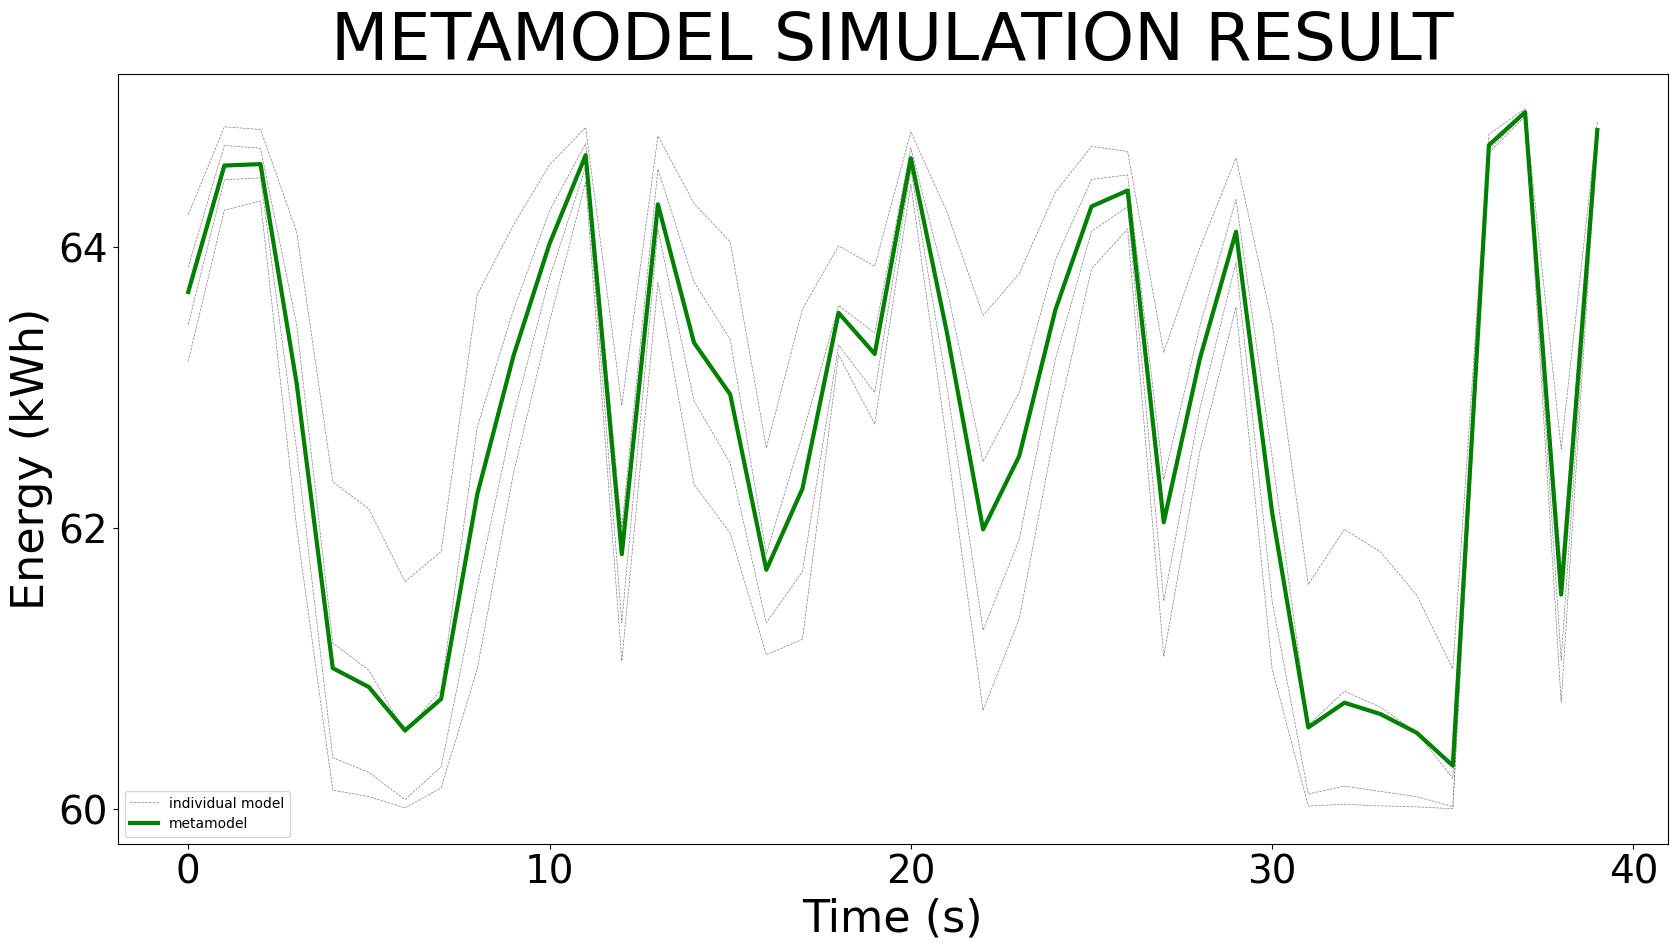

In [7]:
# This calculates the metamodel and plots it, along side with the other plots, which are de-emphazied (hence, gray)
import math
import matplotlib.ticker as ticker


path = f"{BASE_FOLDER}/output/{COMPONENT_TO_ANALYZE}/workload=bitbrains-small/seed=0/"

recent_dir = most_recent_directory(path)
simulation_files = os.listdir(recent_dir)
simulation_data = []
virgin_simulation_data = []

for file in simulation_files:
    simulation_data.append(
        mean_of_chunks(pd.read_parquet(os.path.join(recent_dir, file)), CHUNK_SIZE)
    )
    virgin_simulation_data.append(
        pd.read_parquet(os.path.join(recent_dir, file))
    )
    
sim_data_1 = np.divide(simulation_data[0]['power_total'], 1000)
sim_data_2 = np.divide(simulation_data[1]['power_total'], 1000)
sim_data_3 = np.divide(simulation_data[2]['power_total'], 1000)
sim_data_4 = np.divide(simulation_data[3]['power_total'], 1000)
metamodel_data = []

min_sim_data_len = min(len(sim_data_1), len(sim_data_2), len(sim_data_3), len(sim_data_4))
for i in range(min_sim_data_len):
    # calculate the mean of the power_total using math library
    mean = sim_data_1[i] + sim_data_2[i] + sim_data_3[i] + sim_data_4[i]
    mean /= 4
    metamodel_data.append(mean)
    
# plot all the sim data, in the same plot with gray color, thickness 0.5
plt.figure(figsize=(20, 10))
plt.plot(sim_data_1[:40], color='gray', linewidth=0.5, linestyle='--', markersize=15, markevery=10)
plt.plot(sim_data_2[:40], color='gray', linewidth=0.5, linestyle="--", markersize=15, markevery=10)
plt.plot(sim_data_3[:40], color='gray', linewidth=0.5, linestyle="--", markersize=15, markevery=10)
plt.plot(sim_data_4[:40], color='gray', linewidth=0.5, label='individual model', linestyle="--", markersize=15, markevery=10)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.title('METAMODEL SIMULATION RESULT', fontsize=48)
plt.xlabel('Time (s)', fontsize=32)
plt.ylabel("Energy (kWh)", fontsize=32)
# Set the locator for x and y axis
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
# Set the size of the ticks
plt.tick_params(axis='both', which='major', labelsize=28)
plt.plot(metamodel_data[:40], color='green', linewidth=3, label='metamodel')
# set the legend in bottom left part of the screen
plt.legend(loc='lower left')
plt.savefig('metamodel.png', transparent=False) 
plt.show()

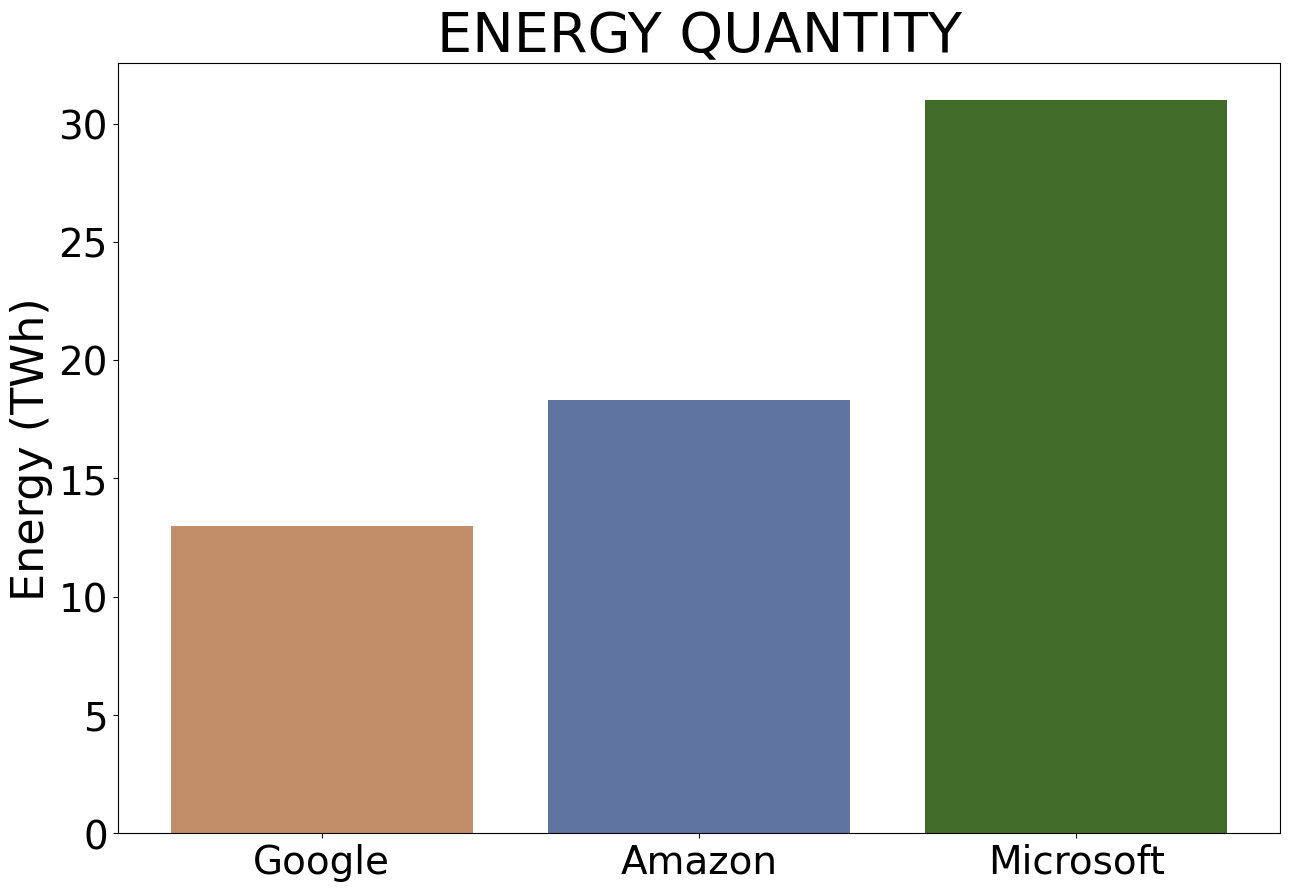

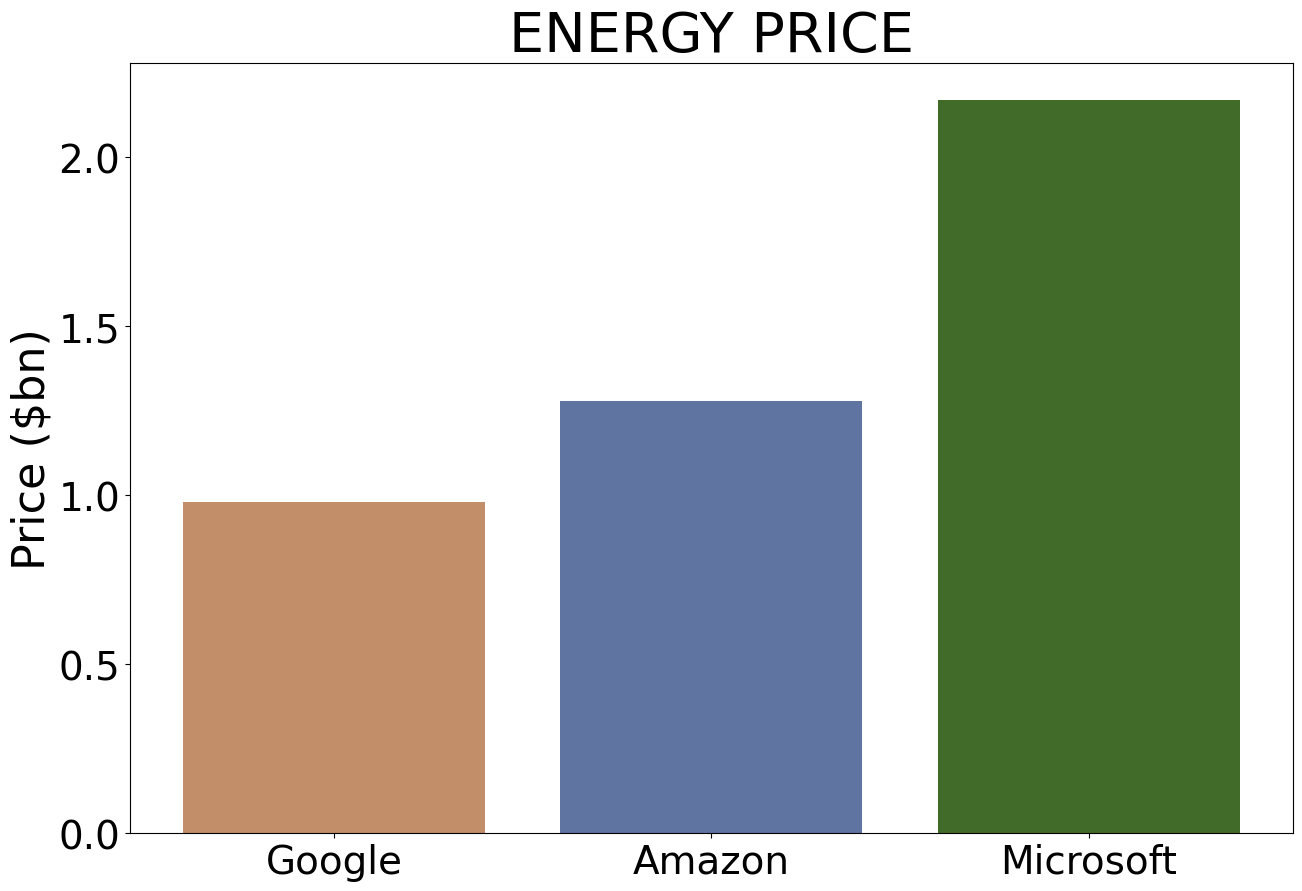

In [8]:
google_consumption = 18.3 # TWh
amazon_consumption = 31 # TWH
microsoft_consumption = 13# TWh

google_price = 1.28
amazon = 2.17
microsoft = 0.98
# Define the colors for each bar
colors = ['#c28d69', '#5f74a0', '#406b29']

# Plot the data as horizontal bars with different colors
fig, ax = plt.subplots(figsize=(15, 10))
bars = ax.bar(['Google', 'Amazon', 'Microsoft'], [microsoft_consumption, google_consumption, amazon_consumption], color=colors)
ax.set_ylabel('Energy (TWh)', fontsize=32)
ax.set_title('ENERGY QUANTITY', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=28)
plt.savefig('energy_consumption_1.png', transparent=False)
plt.show()
# Set the legend

# plot the price of the energy
fig, ax = plt.subplots(figsize=(15, 10))
bars = ax.bar(['Google', 'Amazon', 'Microsoft'], [microsoft, google_price, amazon], color=colors)
ax.set_ylabel('Price ($bn)', fontsize=32)
ax.set_title('ENERGY PRICE', fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=28)

plt.savefig('energy_consumption_2.png', transparent=False)
plt.show()

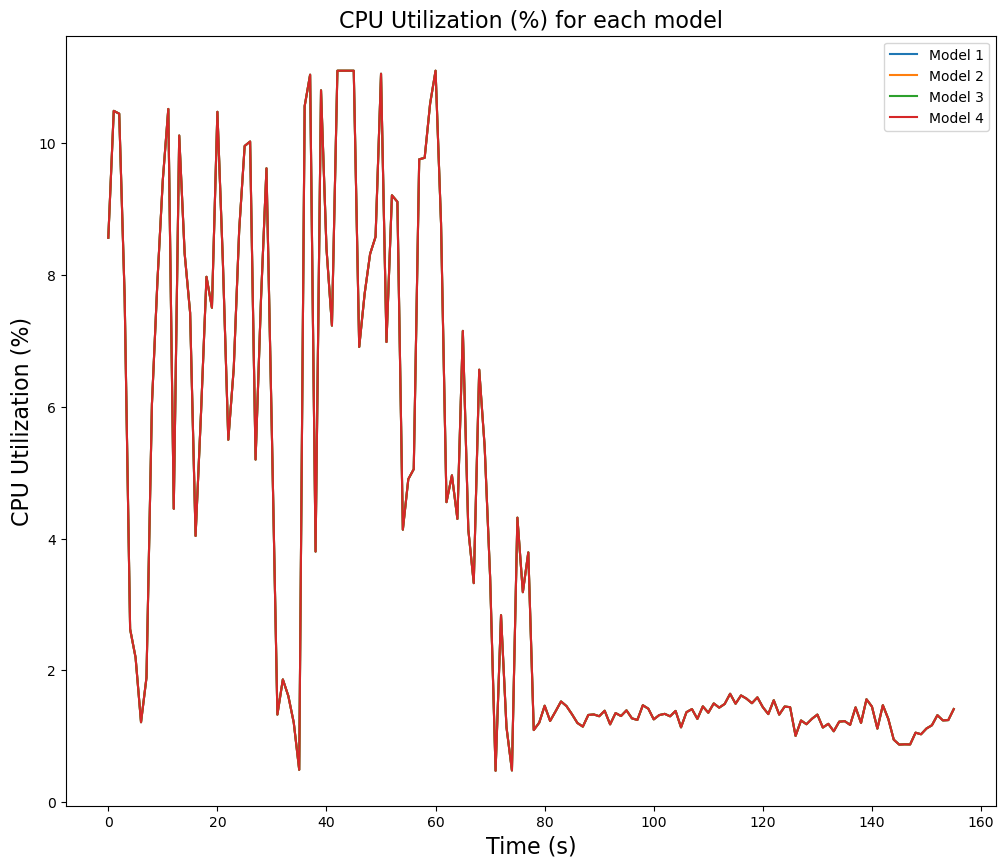

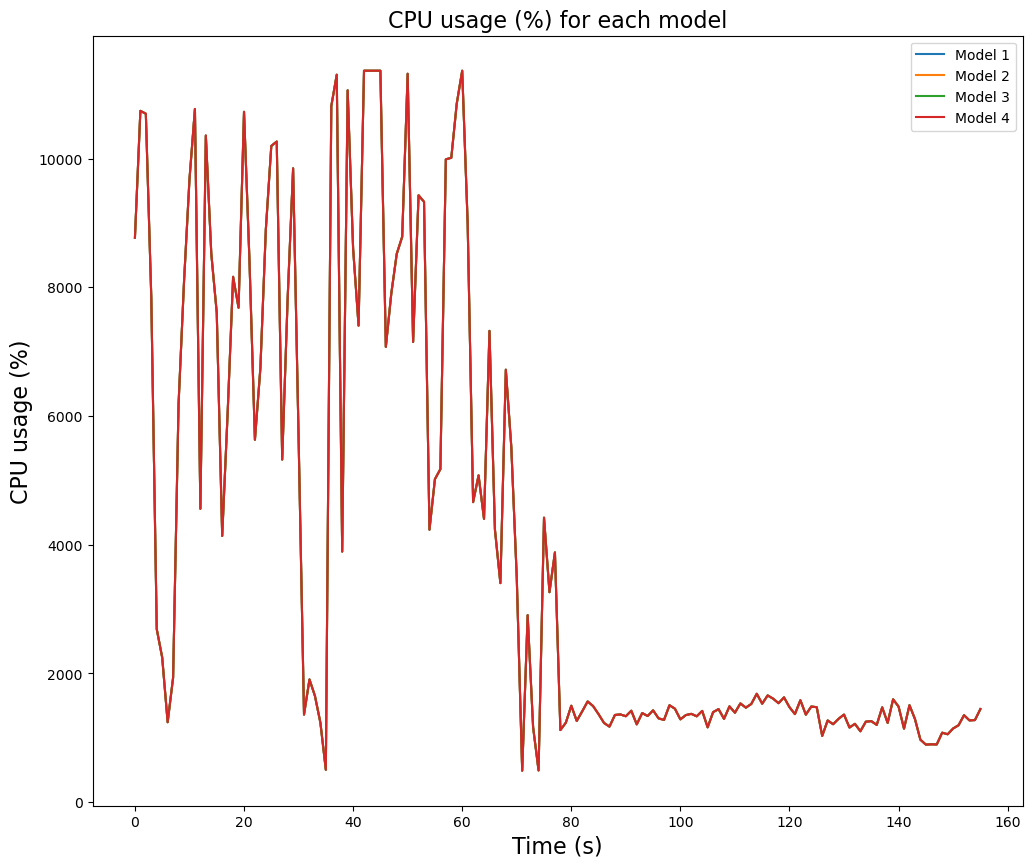

In [9]:
"""
plotter has data taken and averaged over CHUNK_SIZE
virgin_plotter has data taken without averaging
"""

from plotter import DataPlotter
plotter = DataPlotter(simulation_data)
virgin_plotter = DataPlotter(virgin_simulation_data)

for metric in selected_performance_metrics:
    if metric == 'cpu_limit':
        plotter.plot_cpu_limit()
    elif metric == 'cpu_usage':
        plotter.plot_cpu_usage()
    elif metric == 'cpu_demand':
        plotter.plot_cpu_demand()
    elif metric == 'cpu_utilization':
        plotter.plot_cpu_utilization()
    elif metric == 'cpu_time_active':
        plotter.plot_cpu_time_active()
    elif metric == 'cpu_time_idle':
        plotter.plot_cpu_time_idle()
    elif metric == 'cpu_time_steal':
        plotter.plot_cpu_time_steal()
    elif metric == 'cpu_time_lost':
        plotter.plot_cpu_time_lost()
    elif metric == 'mem_capacity':
        plotter.plot_mem_capacity()
        
for metric in selected_energy_metrics:
    if metric == 'power_total':
        # virgin_plotter.plot_power_total_bars()
        plotter.plot_power_total()
        plotter._plot_meta_model('power_total', 'Power Total')

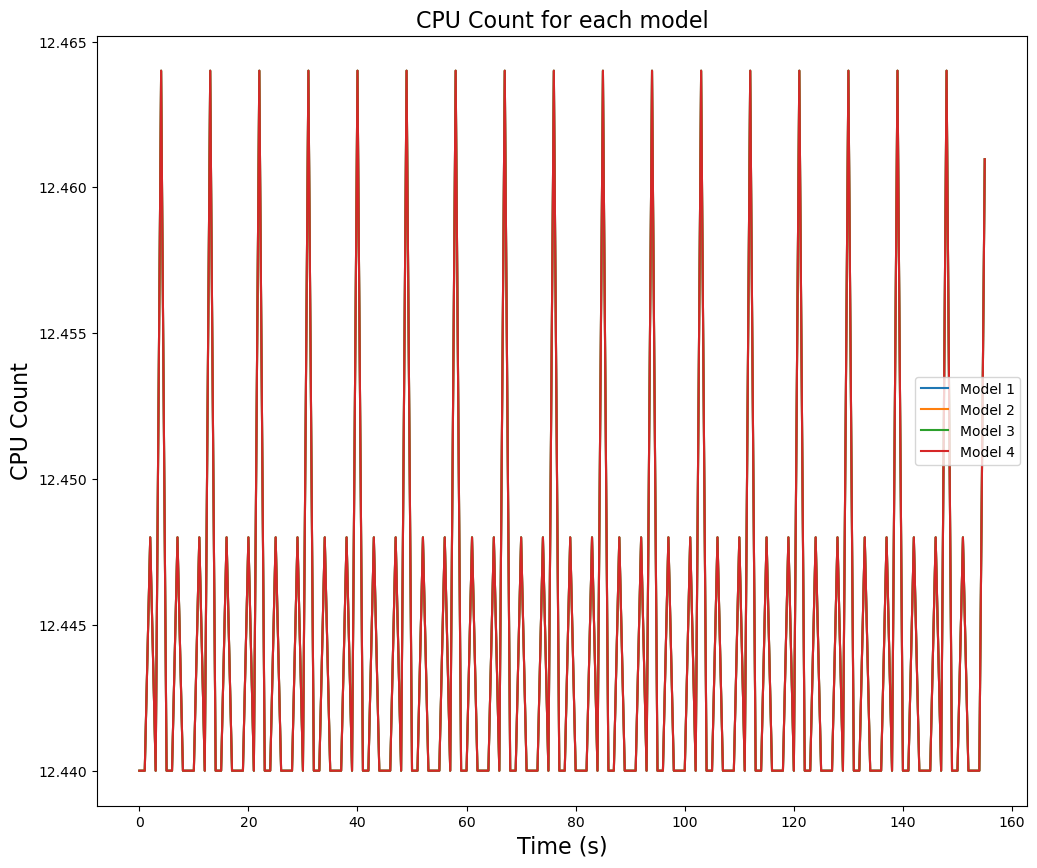

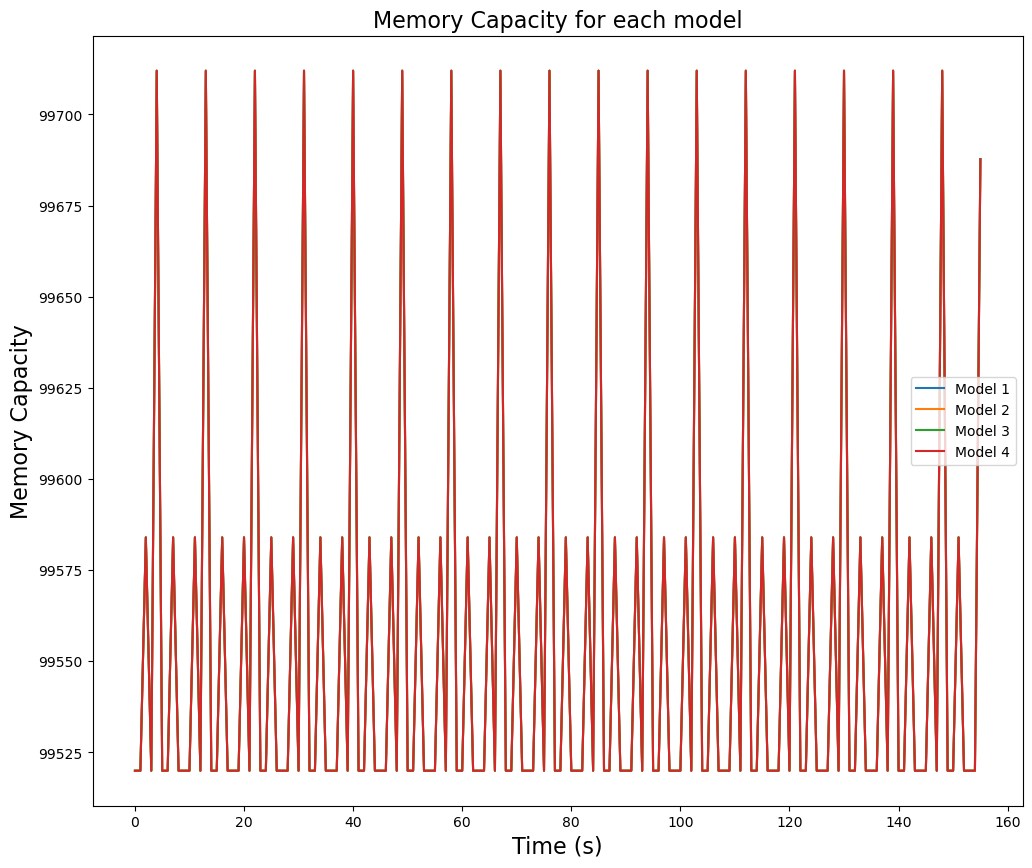

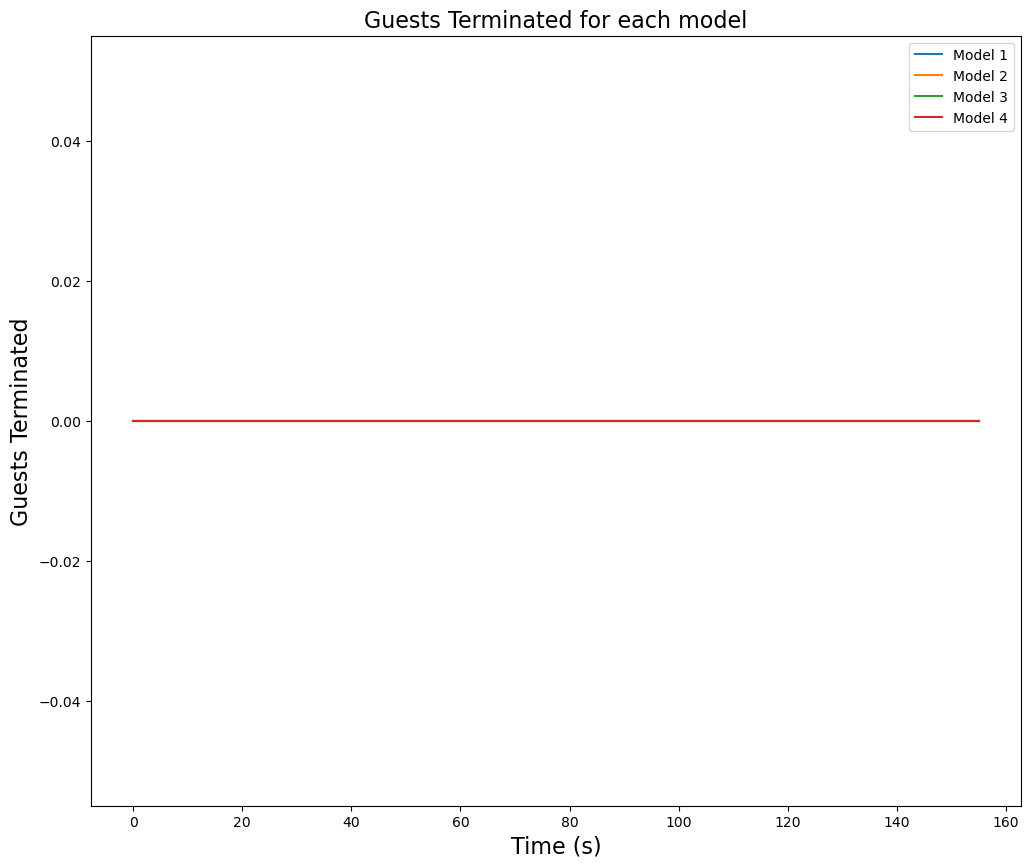

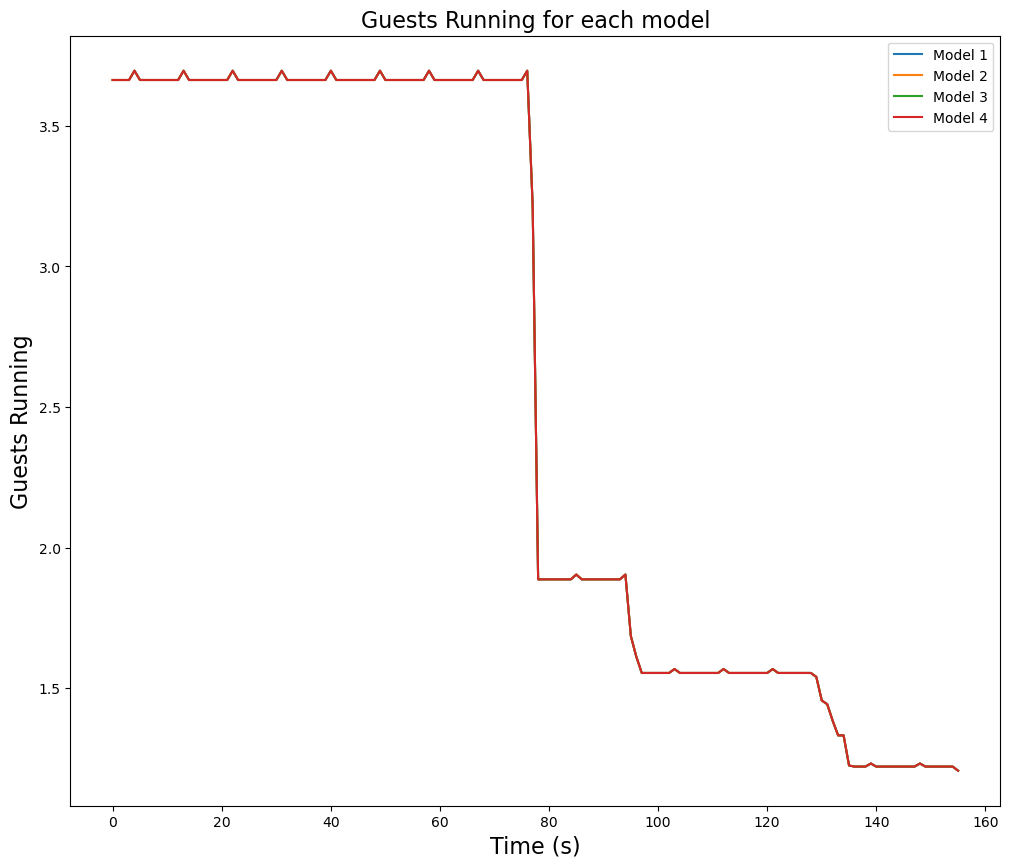

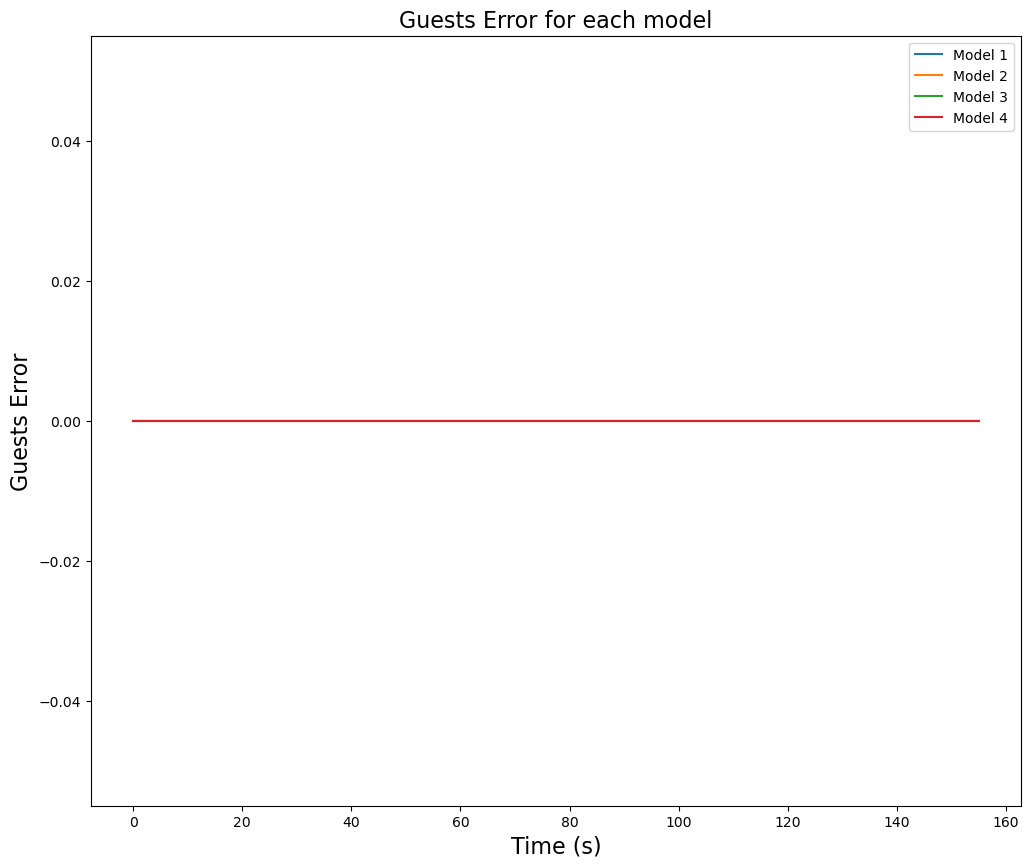

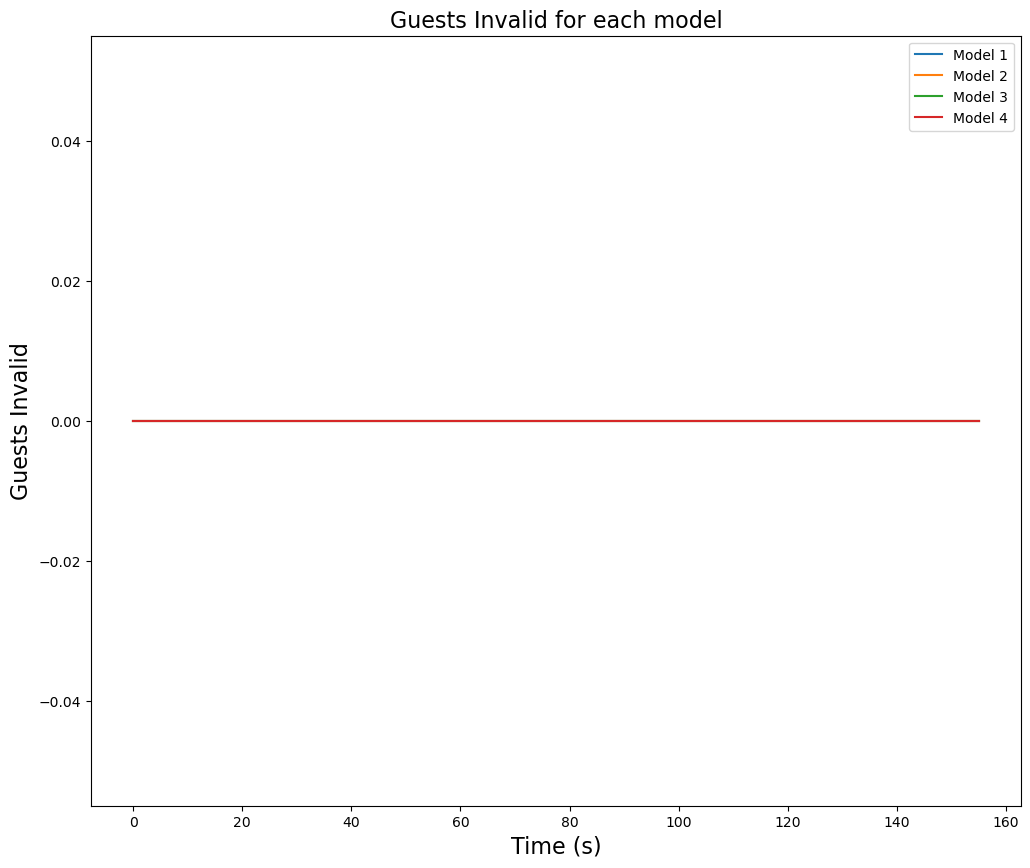

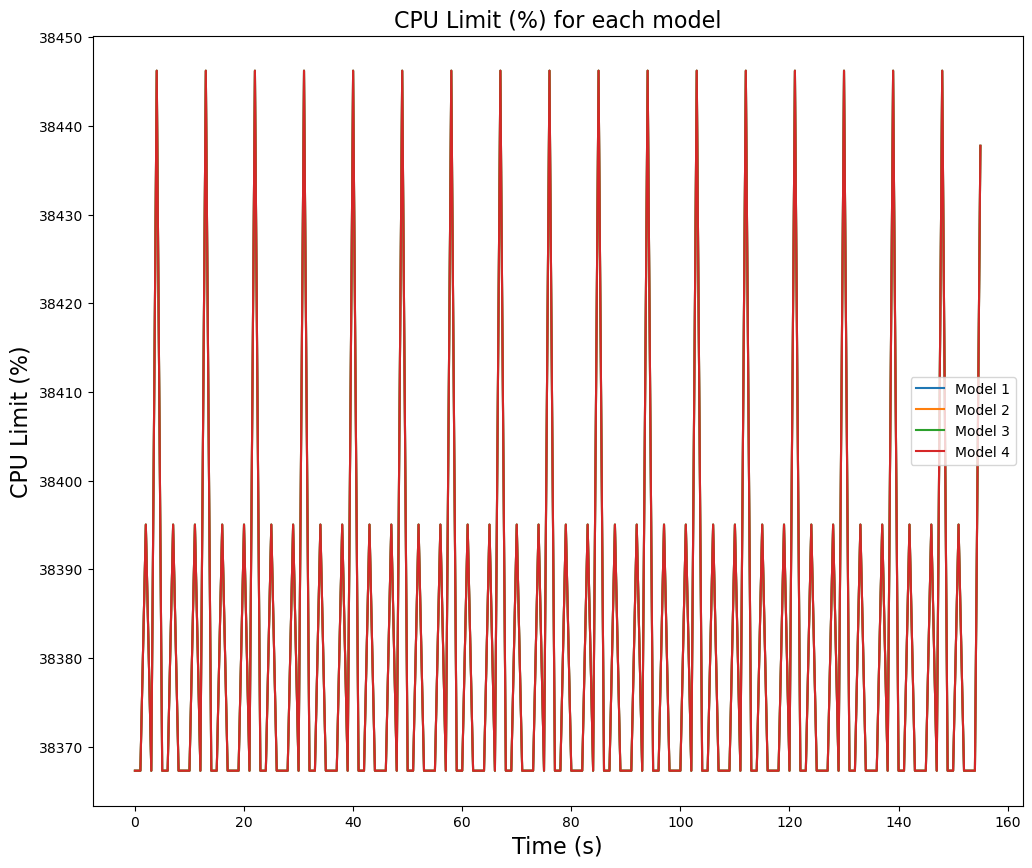

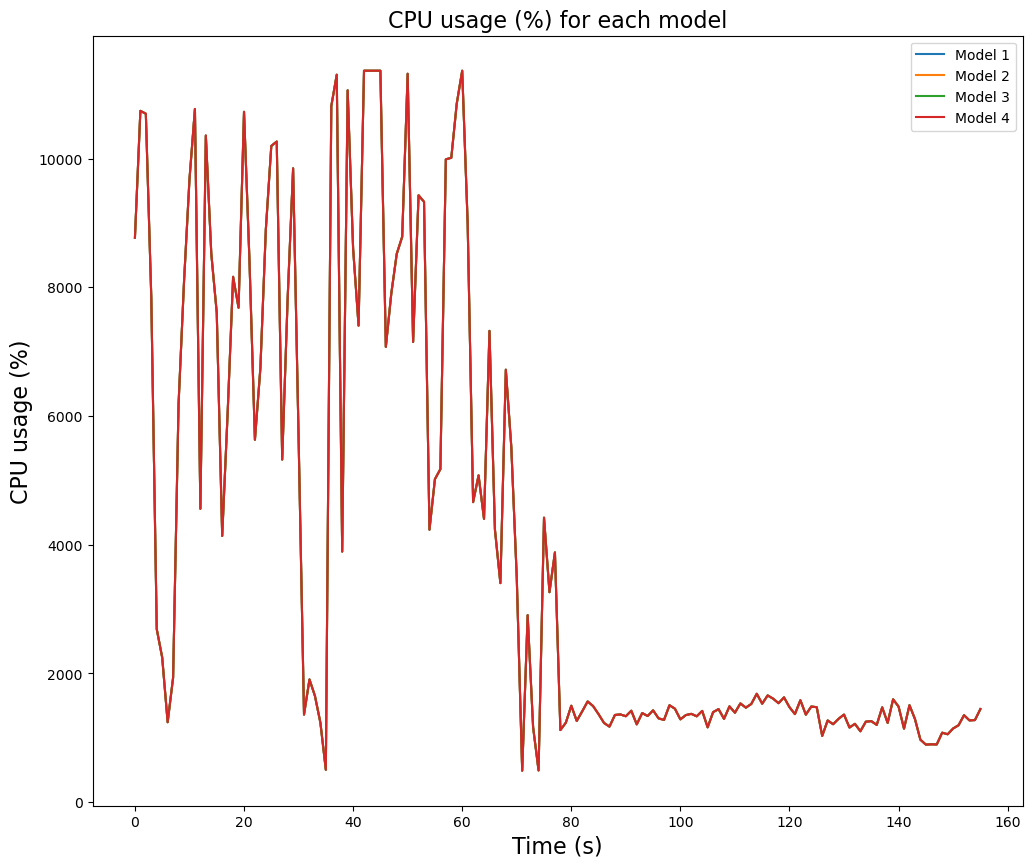

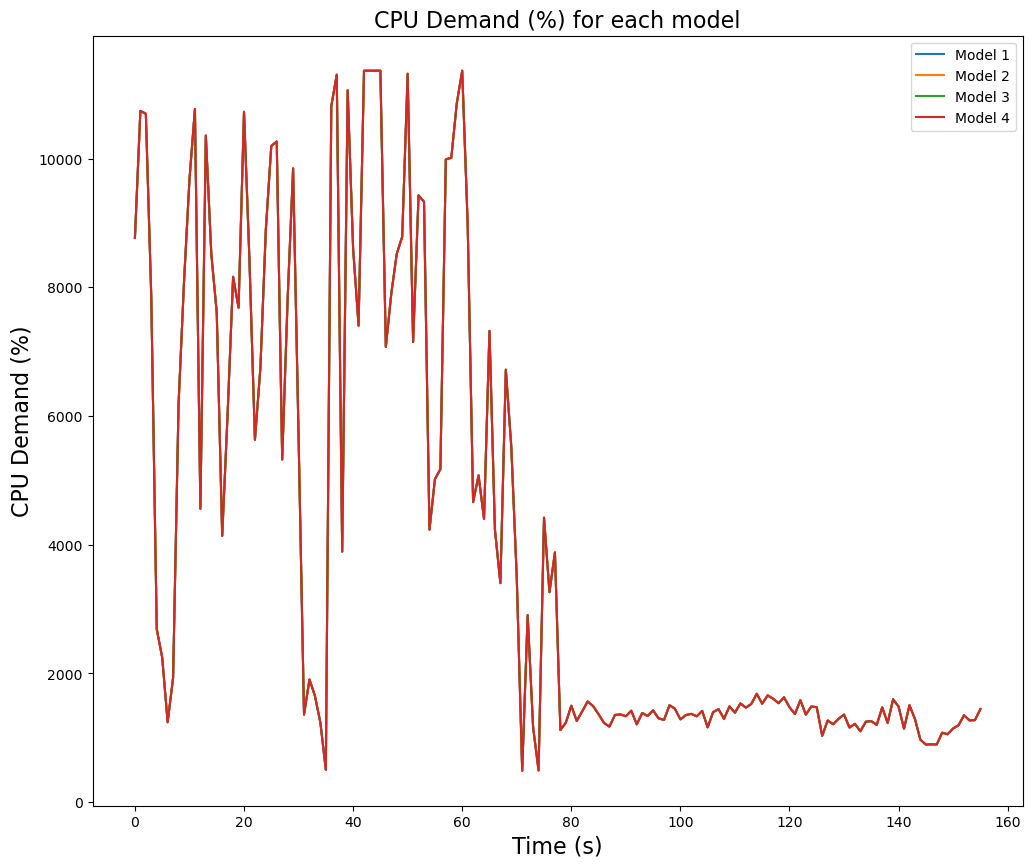

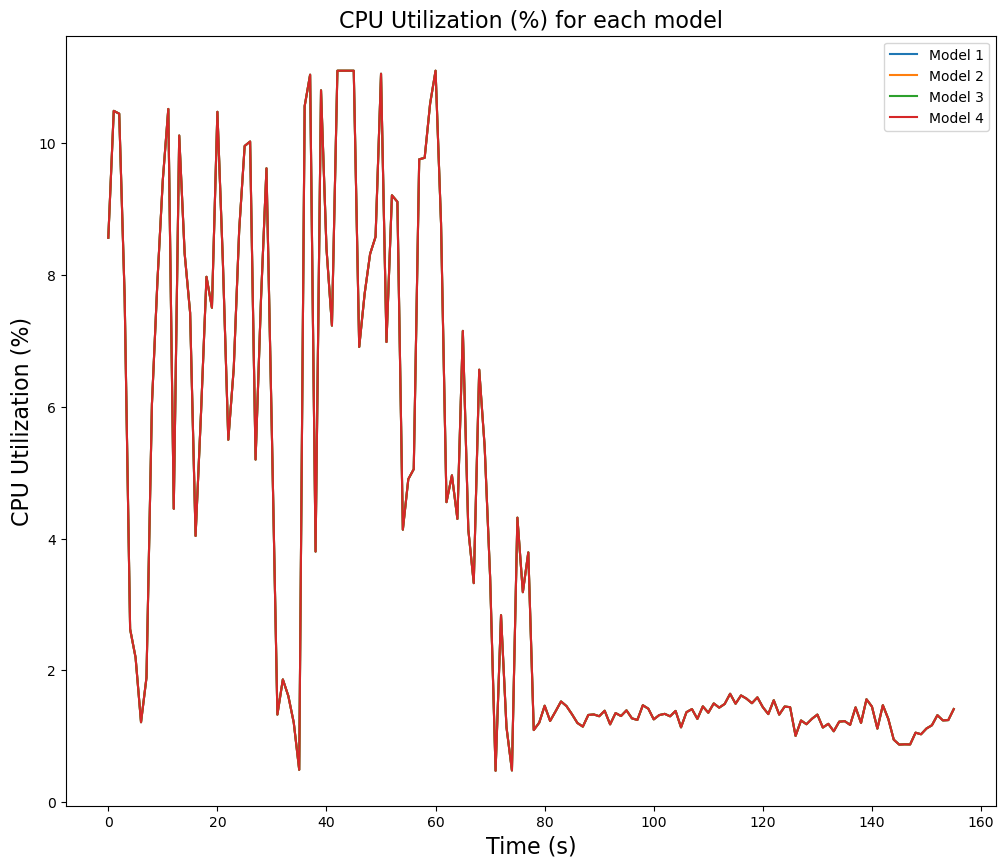

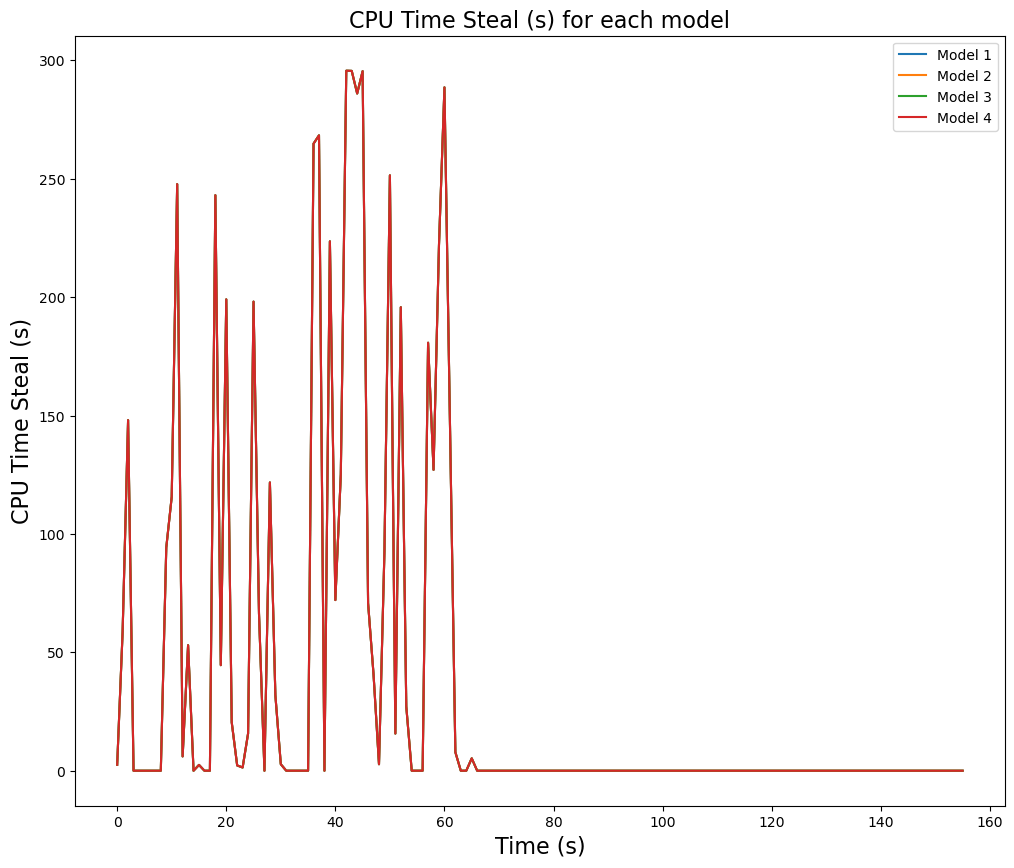

DataFrame does not have 'servers_active' column
DataFrame does not have 'servers_active' column
DataFrame does not have 'servers_active' column
DataFrame does not have 'servers_active' column


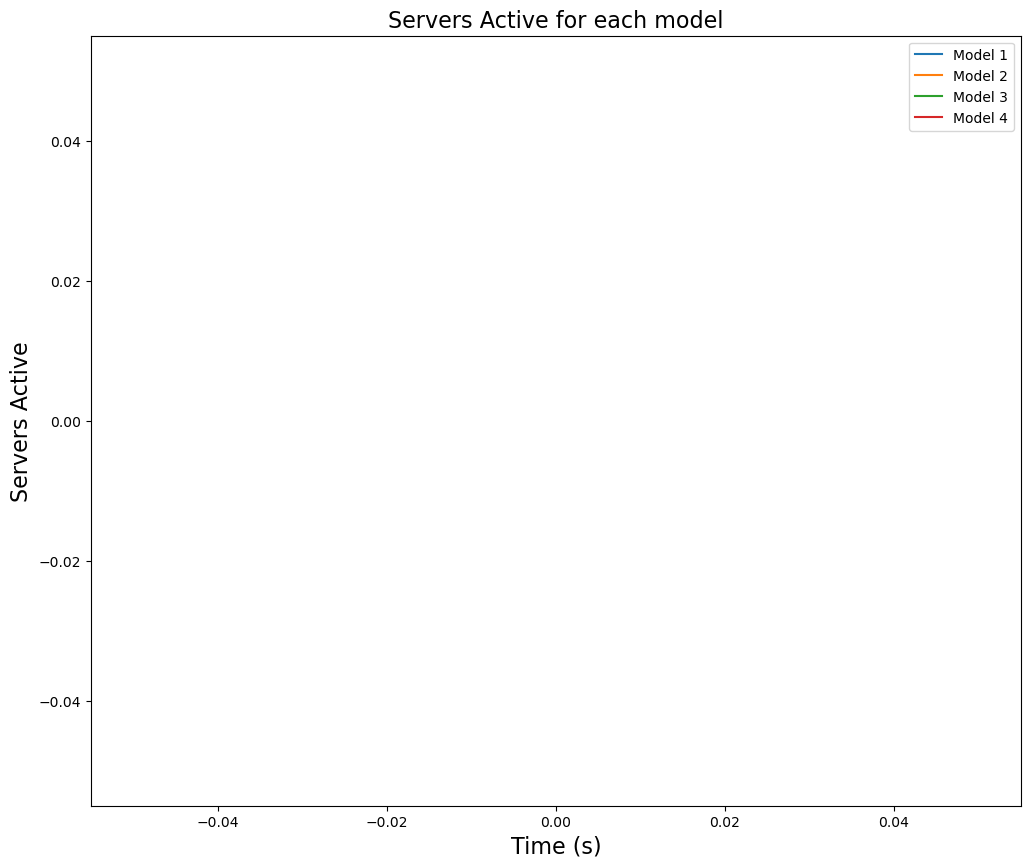

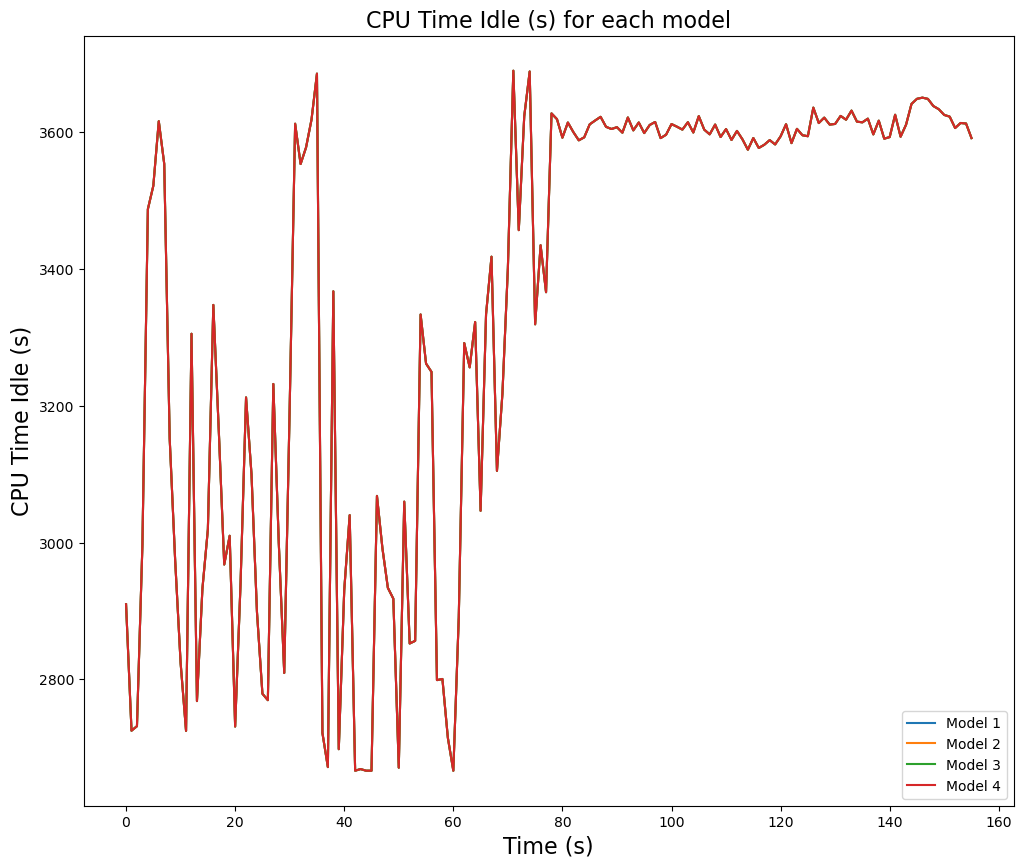

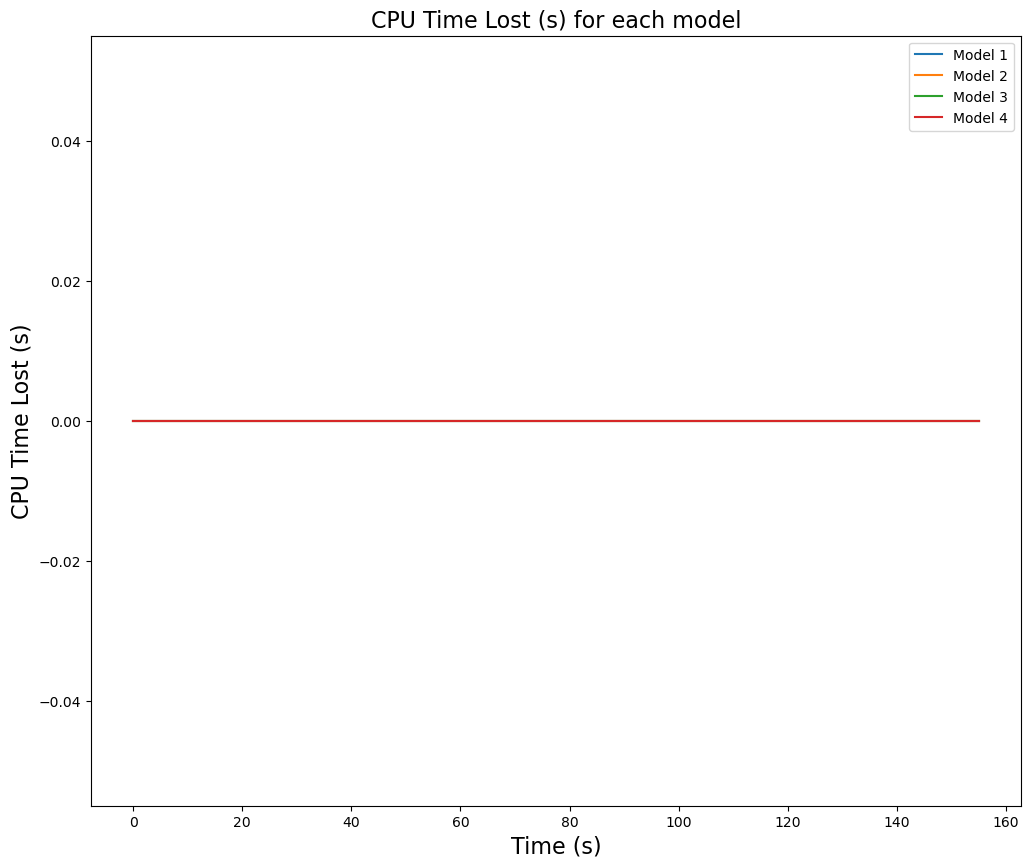

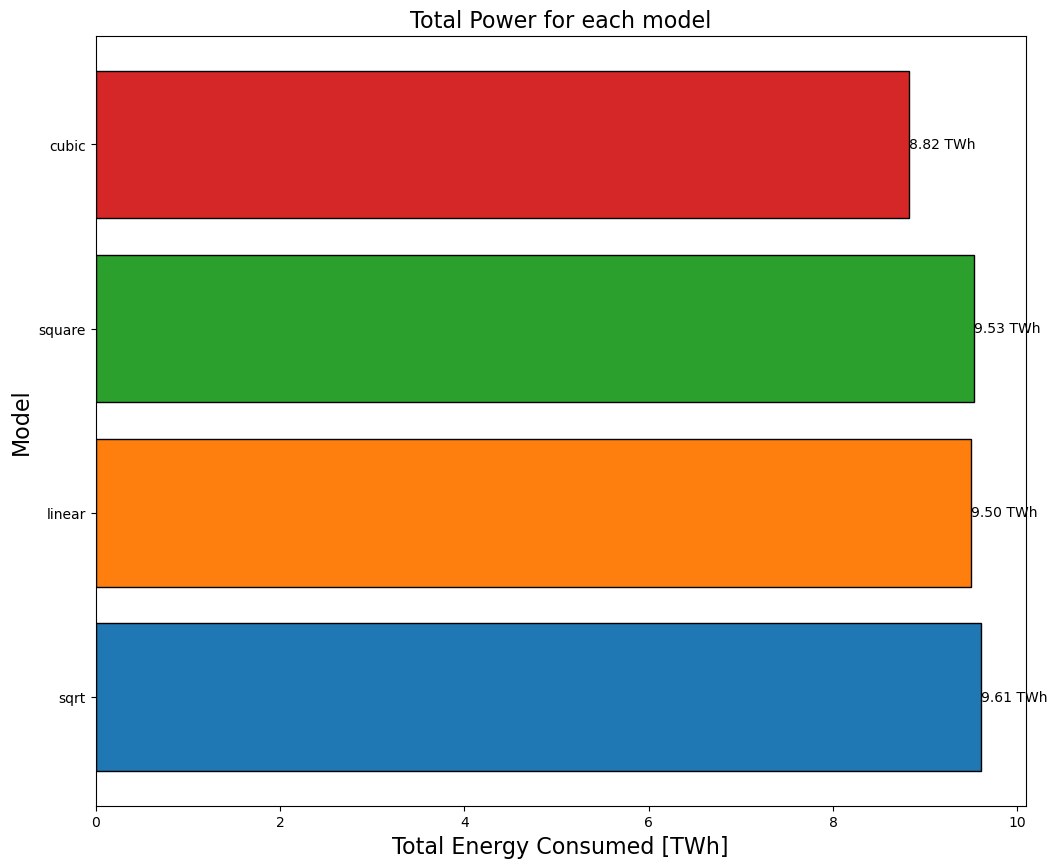

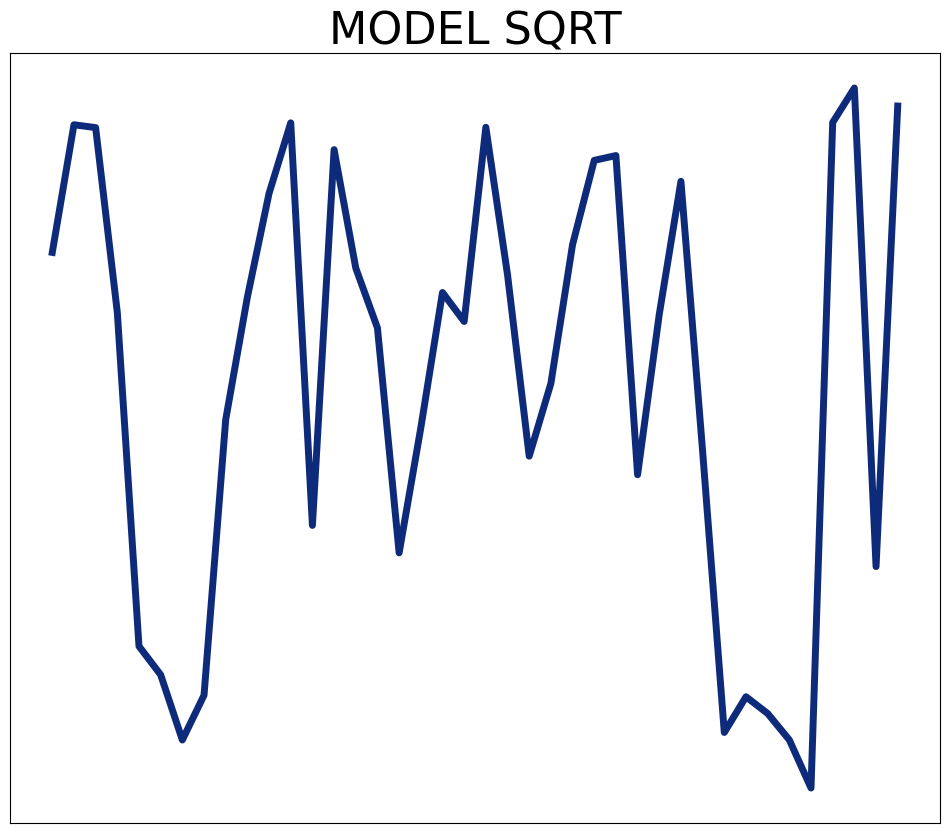

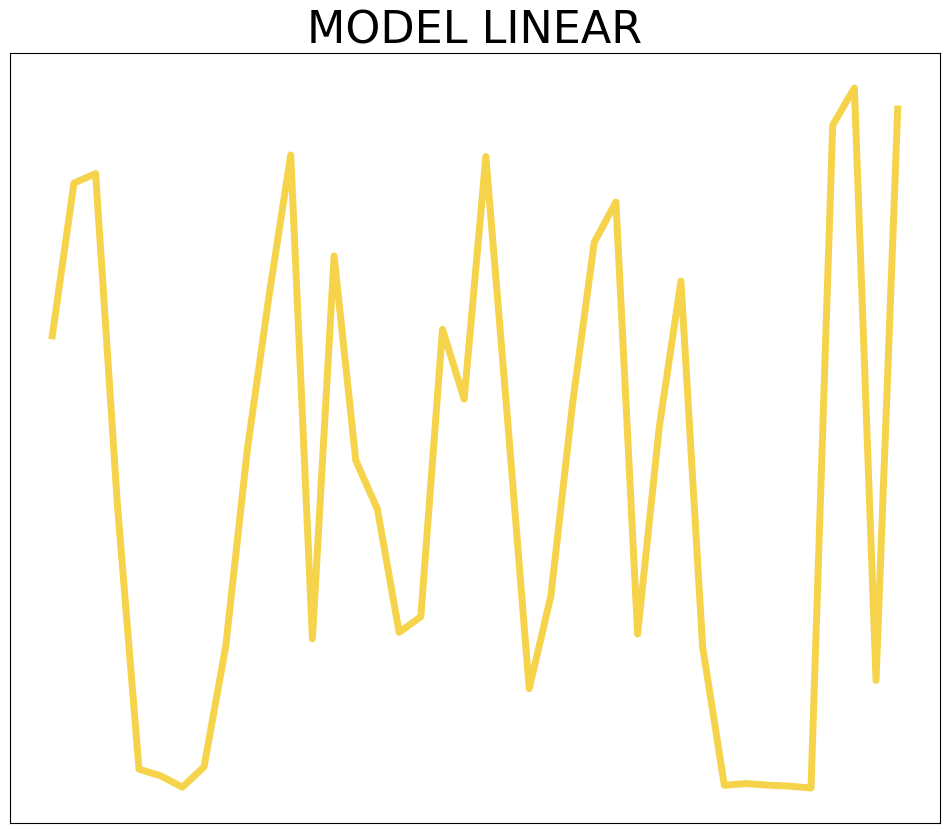

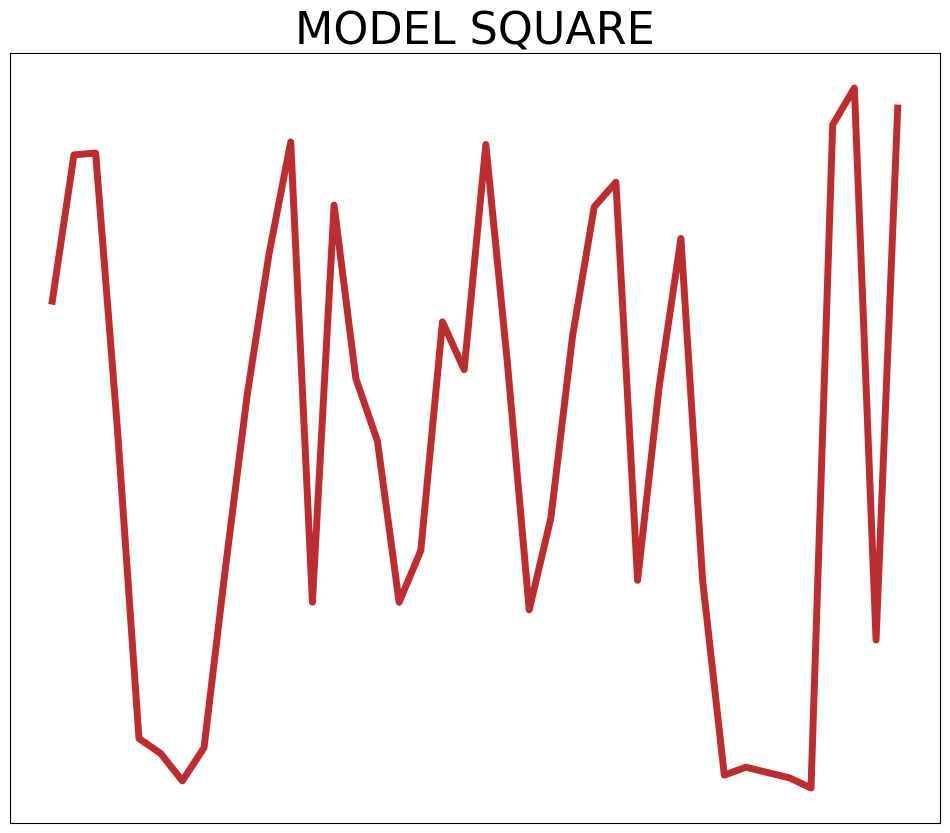

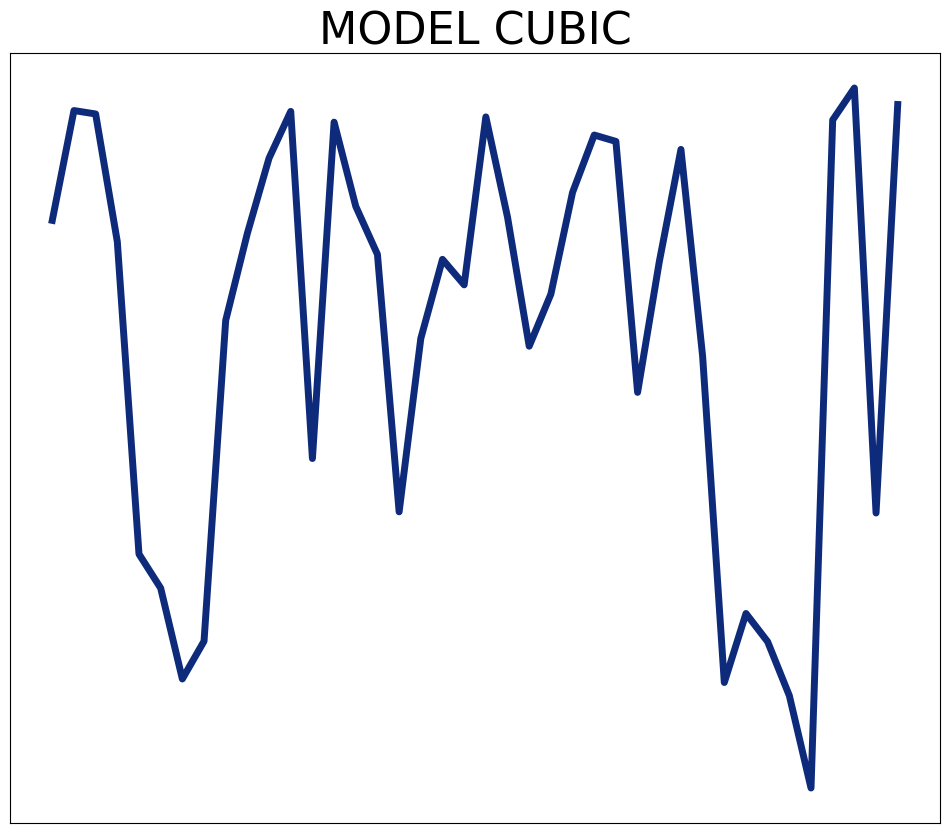

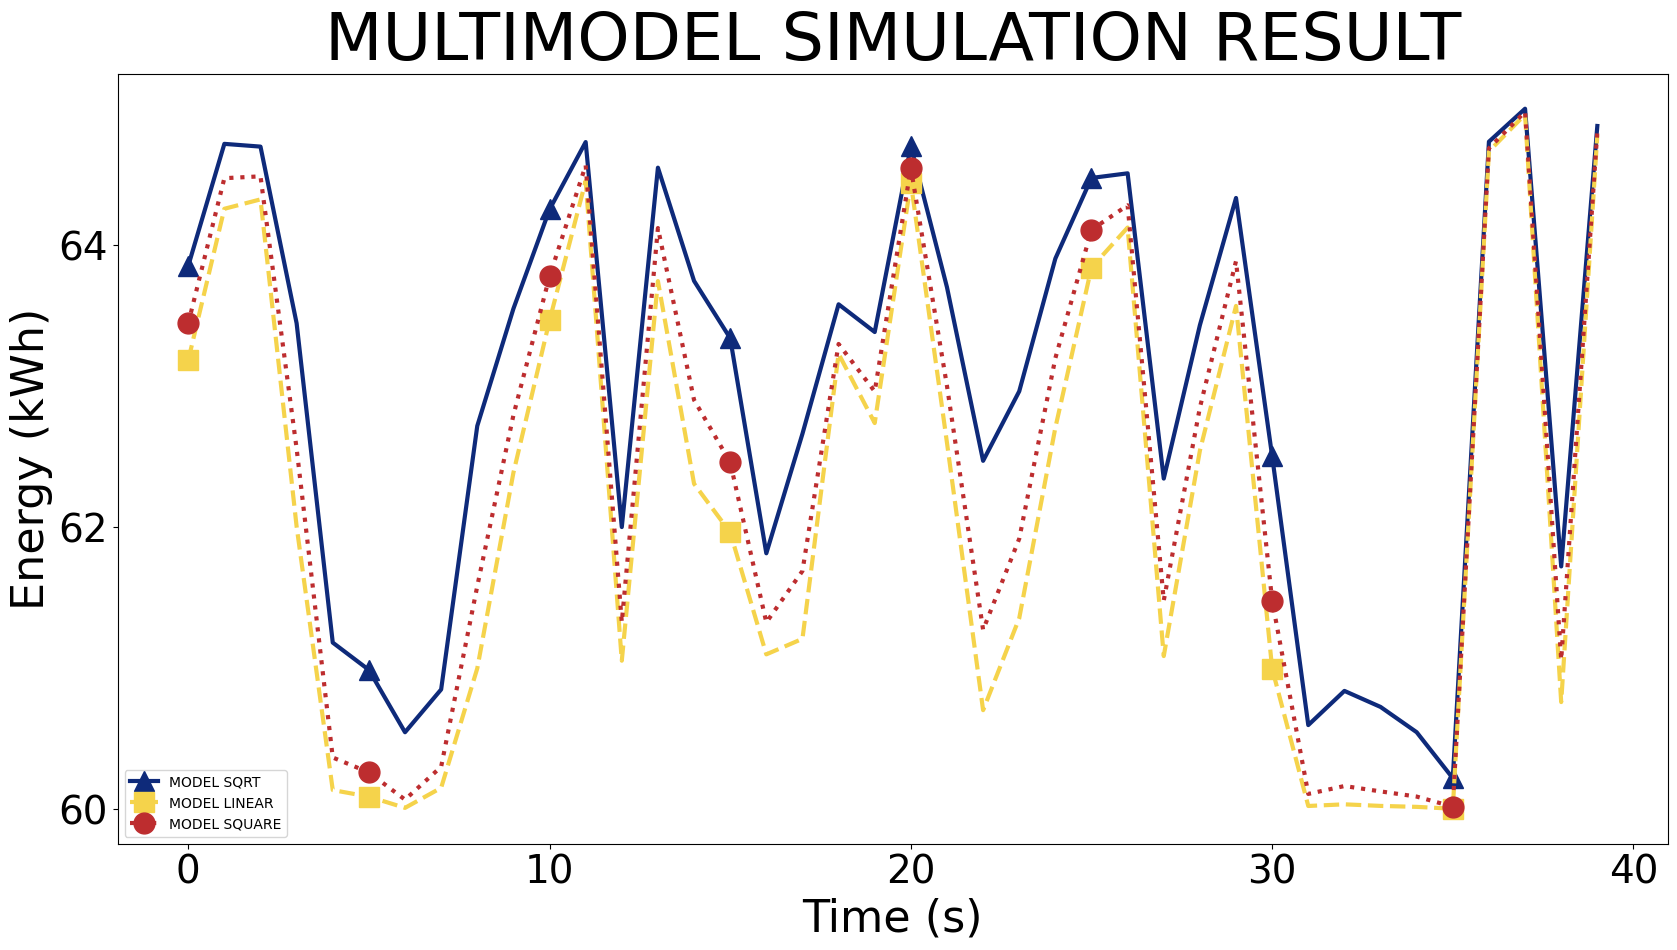

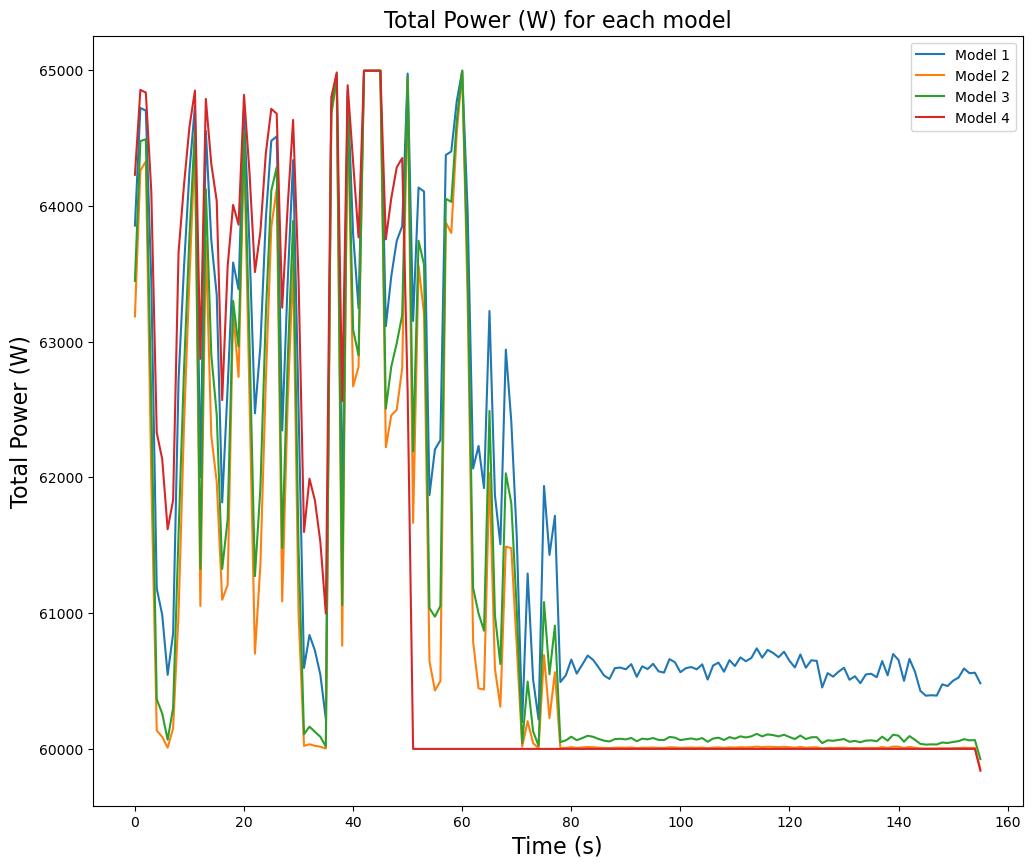

In [10]:
from plotter import DataPlotter
plotter = DataPlotter(simulation_data)


if COMPONENT_TO_ANALYZE == "server":
    plotter.plot_mem_capacity()
    plotter.plot_cpu_count()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_time_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_steal()
    plotter.plot_cpu_time_lost()
elif COMPONENT_TO_ANALYZE == "host":
    plotter.plot_cpu_count()
    plotter.plot_mem_capacity()
    plotter.plot_guests_terminated()
    plotter.plot_guests_running()
    plotter.plot_guests_error()
    plotter.plot_guests_invalid()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_usage()
    plotter.plot_cpu_demand()
    plotter.plot_cpu_utilization()
    plotter.plot_cpu_time_steal()
    plotter.plot_servers_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_lost()
    virgin_plotter.plot_power_total_bars()
    plotter.plot_power_total()
elif COMPONENT_TO_ANALYZE == "service":
    plotter.plot_hosts_up()
    plotter.plot_hosts_down()
    plotter.plot_servers_pending()
    plotter.plot_servers_active()
    plotter.plot_attempts_success()
    plotter.plot_attempts_failure()
    plotter.plot_attempts_error()